# Import Packages and Data

In [1]:
# import necessary libraries
import numpy as np
from scipy.spatial import distance_matrix
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from pyspark.sql.functions import explode
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
# instantiate SparkSession object
spark = SparkSession\
        .builder\
        .appName("ALSExample").config("spark.driver.host","localhost")\
        .getOrCreate()

In [3]:
# read in the dataset into pyspark DataFrame
movie_ratings = spark.read.csv('../data/test_data/ratings.csv', header='true', inferSchema = 'true')


In [4]:
movie_ratings = movie_ratings.drop('timestamp')


# Grid Search Optimal Hyperparameters with Cross Validation

In [154]:
als_model =  ALS(userCol="userId", itemCol="movieId", ratingCol="rating", coldStartStrategy="drop")
               
params = ParamGridBuilder().addGrid(als_model.regParam, [0.15]).addGrid(als_model.rank, [42]).build()
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
## instantiating crossvalidator estimator
cv = CrossValidator(estimator=als_model, estimatorParamMaps=params,evaluator=evaluator,parallelism=4)
best_model = cv.fit(movie_ratings)    

In [155]:
predictions = best_model.transform(movie_ratings)
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 0.6316552600454574


In [156]:
rank = best_model.bestModel.rank
rank

42

In [157]:
best_model.getEstimatorParamMaps()

[{Param(parent='ALS_dca41aee9faa', name='regParam', doc='regularization parameter (>= 0).'): 0.15,
  Param(parent='ALS_dca41aee9faa', name='rank', doc='rank of the factorization'): 42}]

In [158]:
best_model.avgMetrics

[0.8862951748696675]

## Run Model with full data using parameters from grid search

In [159]:
user_factors = best_model.bestModel.userFactors
user_factors.show()

+---+--------------------+
| id|            features|
+---+--------------------+
| 10|[0.42654222, 0.03...|
| 20|[0.42385012, -0.5...|
| 30|[0.32145748, -0.4...|
| 40|[0.25966793, -0.5...|
| 50|[0.25444704, -0.5...|
| 60|[0.23066999, -0.3...|
| 70|[0.20202385, -0.6...|
| 80|[0.25660706, -0.4...|
| 90|[0.6032113, -0.46...|
|100|[0.3782412, -0.17...|
|110|[0.32976493, -0.7...|
|120|[0.40383175, -0.3...|
|130|[0.49857906, -0.3...|
|140|[0.268156, -0.236...|
|150|[0.2596502, -0.47...|
|160|[0.6426705, -0.97...|
|170|[0.27908912, -0.2...|
|180|[0.24244788, -0.5...|
|190|[0.19754475, -0.6...|
|200|[0.5657945, -0.29...|
+---+--------------------+
only showing top 20 rows



In [160]:
recommendationsDF = (user_factors
  .select("id", explode("features")
  .alias("features"))
  .select('id',"features")
)

display(recommendationsDF.show())

+---+------------+
| id|    features|
+---+------------+
| 10|  0.42654222|
| 10|  0.03778477|
| 10|  -0.2214262|
| 10|  -0.1429318|
| 10|  0.41763714|
| 10|  0.28637242|
| 10|   0.4239349|
| 10|-0.113145806|
| 10|  0.08659631|
| 10|  0.21558039|
| 10| -0.17764927|
| 10| -0.13691758|
| 10|-0.086538956|
| 10|  0.08279843|
| 10| 0.056091055|
| 10|  0.85436755|
| 10|  0.06298823|
| 10|   0.7127352|
| 10|  0.25386766|
| 10|  0.18622318|
+---+------------+
only showing top 20 rows



None

In [161]:
rec_pdf = recommendationsDF.toPandas()
rec_pdf.head()

,id,features
0,10,0.426542
1,10,0.037785
2,10,-0.221426
3,10,-0.142932
4,10,0.417637


In [162]:
multiplier = rec_pdf['id'].nunique()
feature_array = np.array(list(range(1,rank+1))*multiplier)
rec_pdf['value'] = feature_array

In [163]:
rec_pdf_unstacked = rec_pdf.pivot(index='id', columns='value', values='features')

In [187]:
rec_pdf_unstacked.head()

value,1,2,3,4,5,6,7,8,9,10,...,33,34,35,36,37,38,39,40,41,42
id,,,,,,,,,,,,,,,,,,,,,
1,0.356424,-0.459595,-0.054893,0.108855,0.223359,0.306445,0.139963,-0.234844,-0.290984,-0.160096,...,0.232461,0.822518,0.109951,-0.150757,0.402179,0.334033,-0.186114,0.336670,-0.333861,-0.359857
2,0.323057,-0.423605,0.186161,-0.250711,0.362462,0.061490,-0.043319,-0.086554,-0.333240,-0.231519,...,0.241000,0.777664,-0.025950,0.083238,0.382216,0.419323,-0.307139,0.073047,-0.400320,-0.285818
3,-0.262564,-0.151385,0.532496,0.703367,0.158847,0.221232,-0.615708,0.022421,-0.125591,-0.622751,...,0.006464,-0.118366,-0.090658,0.296693,0.039114,-0.314430,-0.644133,-0.237932,-0.421944,-0.197373
4,0.183977,-0.506605,-0.351012,0.378343,-0.002804,0.434430,-0.367964,-0.202612,-0.206584,0.162977,...,0.318534,0.854934,-0.197393,-0.240918,-0.014445,0.537394,0.096962,-0.021178,-0.459091,-0.182961
5,0.235266,-0.567842,0.065392,0.121606,0.176664,0.524126,0.019906,-0.011522,-0.280749,-0.117122,...,0.038124,0.694202,-0.178929,-0.203718,0.080843,0.481596,0.063120,0.204460,-0.187315,-0.211709


# Hierarchical Agglomerative Cluster Analysis

In [165]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
rec_pdf_scaled = scaler.fit_transform(rec_pdf_unstacked)

/anaconda3/envs/FI_final_project/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/FI_final_project/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


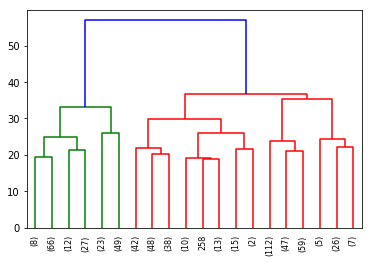

In [166]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
%matplotlib inline

z = linkage(rec_pdf_scaled, 'ward', metric = 'euclidean') # Ward linkage used to produce tightly knit clusters
c, coph_dist = cophenet(z, pdist(rec_pdf_scaled))
dendrogram(z,
          leaf_rotation=90,
          leaf_font_size = 8.,
          truncate_mode='lastp',
          p=20)
plt.show()

In [167]:
coph_dist.sort()
set(coph_dist)

{1.6969282023596046,
 1.8237808392719643,
 1.9159308125196632,
 2.060986934922747,
 2.0843129736787653,
 2.1907556111687194,
 2.2179977798881754,
 2.2528965444902935,
 2.3278410819357003,
 2.3934391764602734,
 2.4117546997534824,
 2.4570152044852662,
 2.469833446744961,
 2.5298849808418415,
 2.5427641553932534,
 2.5581332868970477,
 2.5603614352516013,
 2.666463250034827,
 2.6823707667390684,
 2.7105104512197875,
 2.711068554053174,
 2.7540037564854676,
 2.7611172703985973,
 2.7806521267173885,
 2.7858835011457668,
 2.831561484565073,
 2.832021789798599,
 2.843889396574095,
 2.8482009436118636,
 2.861538592218524,
 2.8770285033892633,
 2.9408064833358143,
 2.9486177240299587,
 2.960728492617511,
 2.961112866053511,
 2.9782729453159282,
 3.0060215087557616,
 3.0295173452835735,
 3.042070718719971,
 3.0518922049666006,
 3.063633340845074,
 3.070528696655297,
 3.0944228073769846,
 3.1659589917642945,
 3.1772722953652246,
 3.1818958955693,
 3.1965975575878076,
 3.209732672666672,
 3.232271

In [168]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import KernelDensity
import pandas as pd
rec_pdf_clustered = pd.DataFrame(rec_pdf_scaled.copy())
cluster = AgglomerativeClustering(n_clusters=5, 
                                 affinity='cosine',
                                 linkage='average')
rec_pdf_clustered['cluster'] = cluster.fit_predict(rec_pdf_scaled)

In [169]:
rec_pdf_clustered.groupby(['cluster']).agg(['mean', 'std', 'count'])

0                         1                         2   \
             mean       std count      mean       std count      mean   
cluster                                                                 
0        0.240284  0.997018   153  0.756058  0.782223   153  0.142716   
1        0.042072  0.930401   171  0.333932  0.883815   171 -0.084117   
2       -0.230618  1.025934   211 -0.767638  0.677153   211 -0.046524   
3       -0.104239  1.140450    41 -0.013925  0.902672    41  0.380773   
4        0.264016  0.685634    34 -0.301078  0.804644    34 -0.389609   

                               3   ...    38        39                  \
              std count      mean  ... count      mean       std count   
cluster                            ...                                   
0        0.956441   153 -0.025796  ...   153  0.069377  0.966090   153   
1        0.912739   171 -0.139869  ...   171 -0.253439  1.011239   171   
2        0.963327   211  0.308116  ...   211  0.223246  0.971071   211   
3        1.437429    41 -0.900571  ...    41 -0.214570  1.104787    41   
4        1.043179    34 -0.006603  ...    34 -0.164236  0.823934    34   

               40                        41                  
             mean       std count      mean       std count  
cluster                                                      
0        0.032476  1.011706   153  0.214789  0.950051   153  
1       -0.090019  0.835187   171  0.236421  0.976040   171  
2       -0.053240  1.019567   211 -0.451240  0.869772   211  
3        0.356010  1.269667    41  0.294812  1.225220    41  
4        0.207699  1.157980    34  0.289224  0.886845    34  

[5 rows x 126 columns]

In [170]:
# from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure(figsize=(20,10))
# ax = fig.add_subplot(111, projection='3d')
# plt.scatter(rec_pdf_clustered[1], rec_pdf_clustered[5], rec_pdf_clustered[3], c=rec_pdf_clustered.cluster)
# plt.show();

In [171]:
cluster_centroids = rec_pdf_clustered.groupby(['cluster']).agg('mean')

In [172]:
cluster_centroids_array = cluster_centroids.to_numpy()

In [173]:
cluster_distance_matrix = distance_matrix(cluster_centroids_array, cluster_centroids_array, p=2)

In [174]:
cluster_distance_df = pd.DataFrame(cluster_distance_matrix)
cluster_distance_df

,0,1,2,3,4
0,0.000000,3.006195,4.149829,4.512238,3.611582
1,3.006195,0.000000,3.960398,3.464399,4.079385
2,4.149829,3.960398,0.000000,3.646043,3.381615
3,4.512238,3.464399,3.646043,0.000000,4.128721
4,3.611582,4.079385,3.381615,4.128721,0.000000


In [175]:
def nearest_clusters(cluster, num_nearest_clusters=2):
    sorted_distances = cluster_distance_df[cluster].sort_values(ascending=True)
    return sorted_distances[1:num_nearest_clusters+1].index.values.astype(int)

In [176]:
nearest_clusters(0, 2)

array([1, 4])

# Bootstrap Sample

In [223]:
bs_sample = rec_pdf_clustered.sample(n=5000, replace=True, axis=0, random_state=42)

# KNN Model (for assigning new user to a cluster)

In [224]:
bs_sample.head()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,cluster
102,0.593223,-0.464291,-0.435269,0.042851,-0.151267,-0.470353,-0.844565,-0.934154,-0.991719,-0.029460,...,1.068516,0.196591,-0.206969,0.268123,0.043600,-0.338972,0.291460,-0.066852,-0.316026,3
435,-0.105210,1.052354,0.441115,0.539285,-0.962024,0.578032,1.013086,1.070378,0.084943,0.272538,...,0.753324,0.743348,-0.794244,-0.802658,0.504055,0.916754,0.690169,0.650762,0.740609,0
270,-0.523583,0.186448,0.945953,0.646214,0.265361,-0.647808,-1.120326,1.023102,-0.629710,0.305860,...,-1.254903,0.342032,-1.472386,-1.088040,-1.103929,-0.495640,0.592695,-0.421399,0.310258,0
106,0.478378,1.015514,0.599919,-0.053453,-0.205486,-0.294124,1.004382,1.268314,-0.434683,0.222320,...,1.431129,0.584427,-0.831904,-0.266389,0.507606,0.395471,1.330619,0.946853,-0.268537,0
71,0.463582,-0.697860,-0.288647,0.427874,-0.412015,-0.072211,-0.470021,0.106778,-0.349729,0.514842,...,0.122854,0.586974,-0.112539,0.465442,-0.109008,-0.274412,0.703604,-0.291377,-0.240852,2


In [225]:
X = bs_sample.iloc[:,:-1]
y = bs_sample.iloc[:,-1]

In [226]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True)

In [227]:
from sklearn.metrics import confusion_matrix
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train,y_train)
train_preds = knn.predict(X_train)
test_preds = knn.predict(X_test)
accuracy_score(y_test, test_preds), accuracy_score(y_train, train_preds)

(0.9688, 0.9856)

In [228]:
print(confusion_matrix(y_test, test_preds))
print(confusion_matrix(y_train, train_preds))

[[309   3   1   0   0]
 [  6 349   0   0   0]
 [  5   7 410   2   0]
 [  0   5   3  78   0]
 [  0   6   1   0  65]]
[[ 932    8    5    0    0]
 [   7 1046    0    0    0]
 [   6   10 1265    2    0]
 [   0    5    3  264    0]
 [   0    6    2    0  189]]


# Nearest Centroid

In [229]:
from sklearn.neighbors import NearestCentroid
nc = NearestCentroid()
nc.fit(X_train, y_train)
nc_train_preds = nc.predict(X_train)
nc_test_preds = nc.predict(X_test)
accuracy_score(y_test, nc_test_preds), accuracy_score(y_train, nc_train_preds)

(0.7768, 0.7885333333333333)

In [230]:
print(confusion_matrix(y_test, nc_test_preds))
print(confusion_matrix(y_train, nc_train_preds))

[[233  25  30   6  19]
 [ 25 266  23  27  14]
 [ 12  33 337  19  23]
 [  4   8   2  72   0]
 [  1   1   7   0  63]]
[[ 710   68   94   27   46]
 [  86  794   64   72   37]
 [  21   81 1055   47   79]
 [  14   23    5  222    8]
 [   5    7    9    0  176]]


# Decision Tree

In [231]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
dc = DecisionTreeClassifier(max_depth=8, max_features=8, criterion='gini', min_samples_leaf=9)
dc.fit(X_train, y_train)
dc_train_preds = dc.predict(X_train)
dc_test_preds = dc.predict(X_test)
accuracy_score(y_test, dc_test_preds), accuracy_score(y_train, dc_train_preds)

(0.88, 0.8941333333333333)

In [232]:
print(confusion_matrix(y_test, dc_test_preds))
print(confusion_matrix(y_train, dc_train_preds))

[[279  12  12   4   6]
 [ 12 320  17   6   0]
 [ 11  13 393   3   4]
 [ 12   7  10  57   0]
 [  4   3  11   3  51]]
[[ 832   45   36   23    9]
 [  33  980   30   10    0]
 [  30   28 1200    8   17]
 [  35   28   15  194    0]
 [  15    9   21    5  147]]


# Random Forest

In [246]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
rf = RandomForestClassifier()
param_grid = {'criterion':['gini', 'entropy'], 
             'max_depth': [15],
             'min_samples_split': [5],
             'n_estimators': [50],
             'max_features': [6]}
gs_forest = GridSearchCV(rf, param_grid, cv=5)
gs_forest.fit(X_train, y_train)
gs_forest.best_params_

{'criterion': 'gini',
 'max_depth': 15,
 'max_features': 6,
 'min_samples_split': 5,
 'n_estimators': 50}

In [247]:
gs_forest_train_preds = gs_forest.predict(X_train)
gs_forest_test_preds = gs_forest.predict(X_test)
accuracy_score(y_test, gs_forest_test_preds), accuracy_score(y_train, gs_forest_train_preds)

(1.0, 1.0)

In [248]:
print(confusion_matrix(y_test, gs_forest_test_preds))
print(confusion_matrix(y_train, gs_forest_train_preds))

[[313   0   0   0   0]
 [  0 355   0   0   0]
 [  0   0 424   0   0]
 [  0   0   0  86   0]
 [  0   0   0   0  72]]
[[ 945    0    0    0    0]
 [   0 1053    0    0    0]
 [   0    0 1283    0    0]
 [   0    0    0  272    0]
 [   0    0    0    0  197]]


# AdaBoost

In [239]:
from sklearn.ensemble import AdaBoostClassifier
ab = AdaBoostClassifier(learning_rate=.4)
ab.fit(X_train, y_train)
ab_train_preds = ab.predict(X_train)
ab_test_preds = ab.predict(X_test)
accuracy_score(y_test, ab_test_preds), accuracy_score(y_train, ab_train_preds)

(0.7456, 0.748)

In [240]:
print(confusion_matrix(y_test, ab_test_preds))
print(confusion_matrix(y_train, ab_train_preds))

[[234  44  30   3   2]
 [ 51 271  29   4   0]
 [  9  41 360  10   4]
 [  2  20  24  40   0]
 [ 12   4  29   0  27]]
[[ 672  151  107    9    6]
 [ 160  819   67    7    0]
 [  42  104 1086   29   22]
 [  13   85   50  124    0]
 [  25    7   61    0  104]]


# Gradient Boosting Classifier

In [241]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
param_grid = {'learning_rate':[.15], 
             'max_depth': [5],
             'min_samples_split': [25],
             'n_estimators': [41],
             'max_features': [7]}
gs_gbc = GridSearchCV(gbc, param_grid, cv=5)
gs_gbc.fit(X_train, y_train)
gbc_train_preds = gs_gbc.predict(X_train)
gbc_test_preds = gs_gbc.predict(X_test)
accuracy_score(y_test, gbc_test_preds), accuracy_score(y_train, gbc_train_preds)

(1.0, 1.0)

In [242]:
gs_gbc.best_params_

{'learning_rate': 0.15,
 'max_depth': 5,
 'max_features': 7,
 'min_samples_split': 25,
 'n_estimators': 41}

In [243]:
print(confusion_matrix(y_test, gbc_test_preds))
print(confusion_matrix(y_train, gbc_train_preds))

[[313   0   0   0   0]
 [  0 355   0   0   0]
 [  0   0 424   0   0]
 [  0   0   0  86   0]
 [  0   0   0   0  72]]
[[ 945    0    0    0    0]
 [   0 1053    0    0    0]
 [   0    0 1283    0    0]
 [   0    0    0  272    0]
 [   0    0    0    0  197]]


# Item Feature Extraction

In [250]:
item_factors = best_model.bestModel.itemFactors
item_factors.show()

+---+--------------------+
| id|            features|
+---+--------------------+
| 10|[0.19412147, -0.1...|
| 20|[0.2040188, -0.28...|
| 30|[0.09493933, -0.8...|
| 40|[0.34263653, -0.2...|
| 50|[0.39503065, -0.7...|
| 60|[0.34756836, -0.2...|
| 70|[0.123617776, -0....|
| 80|[0.26444447, -0.6...|
|100|[0.30453172, -0.3...|
|110|[0.5290467, -0.44...|
|140|[0.2509611, -0.23...|
|150|[0.2753367, -0.38...|
|160|[0.27795386, 0.10...|
|170|[0.29550728, -0.3...|
|180|[0.15804504, -0.7...|
|190|[0.009083749, -0....|
|210|[0.34107968, -0.0...|
|220|[0.2465591, -0.17...|
|230|[0.3595289, -0.40...|
|240|[0.18377262, -0.0...|
+---+--------------------+
only showing top 20 rows



In [251]:
item_factors_df = (item_factors
  .select("id", explode("features")
  .alias("features"))
  .select('id',"features")
)

display(item_factors_df.show())

+---+------------+
| id|    features|
+---+------------+
| 10|  0.19412147|
| 10| -0.16840956|
| 10| -0.05409991|
| 10| -0.03849732|
| 10|  0.36491802|
| 10|  0.32888266|
| 10| -0.01814158|
| 10| -0.10030619|
| 10| -0.23049672|
| 10|-0.005021437|
| 10| -0.17996474|
| 10|-0.043653216|
| 10|   0.2296083|
| 10|  0.15835382|
| 10| -0.12889485|
| 10|  0.71721286|
| 10| 0.014751621|
| 10|   0.7137236|
| 10|   0.1421461|
| 10| 0.104382865|
+---+------------+
only showing top 20 rows



None

In [252]:
item_factors_pdf = item_factors_df.toPandas()
item_factors_pdf.head()

,id,features
0,10,0.194121
1,10,-0.168410
2,10,-0.054100
3,10,-0.038497
4,10,0.364918


In [253]:
multiplier_factors = item_factors_pdf['id'].nunique()
factors_feature_array = np.array(list(range(1,rank+1))*multiplier_factors)
item_factors_pdf['value'] = factors_feature_array
item_factors_unstacked = item_factors_pdf.pivot(index='id', columns='value', values='features')
item_factors_unstacked.head()

value,1,2,3,4,5,6,7,8,9,10,...,33,34,35,36,37,38,39,40,41,42
id,,,,,,,,,,,,,,,,,,,,,
1,0.223121,-0.504545,0.055278,0.160817,0.170769,0.419735,0.103934,0.019618,-0.209311,-0.085529,...,0.096205,0.810226,-0.021335,-0.029396,0.249989,0.552417,-0.008606,0.179189,-0.211937,-0.250459
2,0.356870,-0.246326,0.161739,0.089959,0.088285,0.281784,0.033327,-0.002501,-0.292612,-0.143695,...,0.158359,0.720528,0.050820,-0.058412,0.300903,0.286433,-0.091045,0.387048,-0.033233,-0.100459
3,0.349141,-0.298126,0.215951,-0.093202,0.197308,0.303075,0.117200,-0.012414,-0.342492,-0.036733,...,0.050101,0.773211,0.128463,-0.135424,0.138264,0.247502,-0.165812,0.288258,-0.102235,-0.138866
4,0.244874,-0.069763,0.080209,-0.029756,0.072073,0.158038,0.062505,-0.024358,-0.344232,0.299336,...,0.224035,0.500683,-0.115949,-0.184933,0.206216,0.394924,-0.071689,0.250634,0.107449,0.028042
5,0.411324,-0.089423,0.061362,0.061981,0.078258,0.167156,0.014124,-0.151635,-0.270109,-0.141758,...,0.324585,0.634212,0.117804,-0.093904,0.224140,0.319737,-0.092807,0.232144,-0.097103,-0.123344


# Cluster Centroids

In [254]:
cluster_centroids_df = pd.DataFrame(cluster_centroids_array)
cluster_centroids_df.head()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,0.240284,0.756058,0.142716,-0.025796,-0.258901,0.215406,0.510809,0.581457,0.250940,-0.059889,...,-0.299106,0.256088,0.213725,-0.015607,-0.231078,0.294894,-0.015055,0.069377,0.032476,0.214789
1,0.042072,0.333932,-0.084117,-0.139869,0.182940,-0.460459,0.152727,-0.418614,0.246540,-0.380719,...,-0.276426,0.156815,0.500339,0.364888,0.518568,-0.280393,-0.569063,-0.253439,-0.090019,0.236421
2,-0.230618,-0.767638,-0.046524,0.308116,0.076726,0.269992,-0.552754,0.116364,-0.256091,0.316073,...,0.325416,-0.418394,-0.464147,-0.212569,-0.247732,-0.096628,0.372967,0.223246,-0.053240,-0.451240
3,-0.104239,-0.013925,0.380773,-0.900571,-0.030488,-0.574274,-0.091118,-0.559474,-0.571396,0.153238,...,0.343328,0.138814,0.258442,0.014770,0.113016,-0.183116,-0.218361,-0.214570,0.356010,0.294812
4,0.264016,-0.301078,-0.389609,-0.006603,-0.194414,0.363477,0.473437,-0.558660,-0.090879,0.037997,...,0.302730,0.488028,-0.909381,-0.463571,-0.167131,0.903668,0.878526,-0.164236,0.207699,0.289224


In [255]:
cluster_centroids.shape

(5, 42)

In [256]:
item_factors_unstacked_transposed = item_factors_unstacked.T

In [257]:
centroid_ratings = np.dot(cluster_centroids, item_factors_unstacked_transposed)

In [258]:
centroid_ratings_df = pd.DataFrame(centroid_ratings)
centroid_ratings_df.head(n=10)

,0,1,2,3,4,5,6,7,8,9,...,9714,9715,9716,9717,9718,9719,9720,9721,9722,9723
0,0.432597,0.807473,0.235284,0.688007,0.824466,-0.485126,1.117152,0.849592,0.862183,0.106020,...,-0.977717,-0.838043,-1.117391,-1.117391,-0.977717,-1.117391,-0.977717,-0.977717,-0.977717,-1.423317
1,0.663980,0.793041,0.703307,0.183635,0.923310,0.493569,0.204512,1.353295,1.428278,1.281715,...,0.652402,0.559201,0.745602,0.745602,0.652402,0.745602,0.652402,0.652402,0.652402,0.178666
2,-0.522544,-0.889739,-0.536096,-0.637224,-1.083732,0.372691,-0.663195,-1.294365,-1.350833,-0.713920,...,0.306493,0.262708,0.350277,0.350277,0.306493,0.350277,0.306493,0.306493,0.306493,1.028558
3,-2.450873,-1.861585,-0.762285,-0.583702,-1.414394,-1.912550,-2.056999,-1.197563,-1.715426,-1.560769,...,-0.699436,-0.599517,-0.799356,-0.799356,-0.699436,-0.799356,-0.699436,-0.699436,-0.699436,-0.991144
4,0.912193,0.144308,-0.349820,0.638800,0.077298,-0.305863,0.540447,-1.152643,-0.611509,-0.610753,...,0.059909,0.051351,0.068468,0.068468,0.059909,0.068468,0.059909,0.059909,0.059909,0.318435


In [259]:
centroid_ratings_df.columns = item_factors_unstacked.index
centroid_ratings_df.head()

id,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
0,0.432597,0.807473,0.235284,0.688007,0.824466,-0.485126,1.117152,0.849592,0.862183,0.106020,...,-0.977717,-0.838043,-1.117391,-1.117391,-0.977717,-1.117391,-0.977717,-0.977717,-0.977717,-1.423317
1,0.663980,0.793041,0.703307,0.183635,0.923310,0.493569,0.204512,1.353295,1.428278,1.281715,...,0.652402,0.559201,0.745602,0.745602,0.652402,0.745602,0.652402,0.652402,0.652402,0.178666
2,-0.522544,-0.889739,-0.536096,-0.637224,-1.083732,0.372691,-0.663195,-1.294365,-1.350833,-0.713920,...,0.306493,0.262708,0.350277,0.350277,0.306493,0.350277,0.306493,0.306493,0.306493,1.028558
3,-2.450873,-1.861585,-0.762285,-0.583702,-1.414394,-1.912550,-2.056999,-1.197563,-1.715426,-1.560769,...,-0.699436,-0.599517,-0.799356,-0.799356,-0.699436,-0.799356,-0.699436,-0.699436,-0.699436,-0.991144
4,0.912193,0.144308,-0.349820,0.638800,0.077298,-0.305863,0.540447,-1.152643,-0.611509,-0.610753,...,0.059909,0.051351,0.068468,0.068468,0.059909,0.068468,0.059909,0.059909,0.059909,0.318435


In [260]:
len(centroid_ratings_df.columns)

9724

In [261]:
centroid_ratings_T_df = centroid_ratings_df.transpose()
centroid_ratings_T_df.head()

,0,1,2,3,4
id,,,,,
1,0.432597,0.663980,-0.522544,-2.450873,0.912193
2,0.807473,0.793041,-0.889739,-1.861585,0.144308
3,0.235284,0.703307,-0.536096,-0.762285,-0.349820
4,0.688007,0.183635,-0.637224,-0.583702,0.638800
5,0.824466,0.923310,-1.083732,-1.414394,0.077298


# New User Data

In [262]:
user_id = 100000
user_ratings_1 = [(user_id,3253,5),
                  (user_id,2459,5),
                  (user_id,2513,4),
                  (user_id,6502,5),
                  (user_id,1091,5),
                  (user_id,441,4)]

## ALS recommendations

In [263]:
rated_movies = [3253,2459,2513,6502,1091,441]
rated_item_factor = item_factors_pdf.loc[item_factors_pdf['id'].isin(rated_movies)].pivot(index='id', columns='value', values='features')
M = rated_item_factor.as_matrix()
E = np.identity(rank)
nui = 6
regParam = 0.01
A = M.dot(M.T)
R = np.array([x[2] for x in user_ratings_1])

/anaconda3/envs/FI_final_project/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [264]:
A = M.T.dot(M)+regParam*nui*E
V = M.T.dot(R.T)

In [265]:
A

array([[ 1.01351404, -0.97242051,  0.30776337, ...,  0.45620355,
        -0.5207755 , -0.43734366],
       [-0.97242051,  1.66820377, -0.21107458, ..., -0.69285178,
         0.74004   ,  0.68357402],
       [ 0.30776337, -0.21107458,  0.44284907, ...,  0.18958919,
        -0.13968644, -0.07600837],
       ...,
       [ 0.45620355, -0.69285178,  0.18958919, ...,  0.51960653,
        -0.31580326, -0.37221029],
       [-0.5207755 ,  0.74004   , -0.13968644, ..., -0.31580326,
         0.42998069,  0.31726739],
       [-0.43734366,  0.68357402, -0.07600837, ..., -0.37221029,
         0.31726739,  0.42204642]])

In [266]:
V

array([ 11.07926798, -12.42600664,   3.34087037,   1.23646763,
         2.41359417,   7.8804261 ,   1.45566056,  -4.71284577,
        -7.38547409,  -1.59262385,  -0.25610026,  -1.89764723,
         2.21947494,   3.8145166 ,  -6.89786525,  20.83289552,
        -0.28867782,  16.25750202,  -0.32018324,  -2.75435117,
         0.95598936, -10.01700965,  -5.43807377,  -2.65670503,
         9.07599133,  -2.70720496,  -6.37343226,  -5.22713514,
         9.37834752,   2.41168562,   7.88645048,   7.31233378,
         6.64115039,  17.36357242,   1.1403698 ,  -2.72836117,
        10.4823777 ,   9.72271734,  -0.41381541,   6.05010068,
        -6.37867066,  -5.784831  ])

In [267]:
user_fac = np.linalg.inv(A).dot(V)

In [268]:
item_factors_unstacked.T

id,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
value,,,,,,,,,,,,,,,,,,,,,
1,0.223121,0.356870,0.349141,0.244874,0.411324,0.227014,0.263773,0.202245,0.285656,0.194121,...,0.020404,0.017489,0.023319,0.023319,0.020404,0.023319,0.020404,0.020404,0.020404,0.262732
2,-0.504545,-0.246326,-0.298126,-0.069763,-0.089423,-0.525850,-0.229041,0.031637,-0.243588,-0.168410,...,-0.384393,-0.329480,-0.439307,-0.439307,-0.384393,-0.439307,-0.384393,-0.384393,-0.384393,-0.699312
3,0.055278,0.161739,0.215951,0.080209,0.061362,0.077607,0.082635,0.204705,0.019399,-0.054100,...,0.115275,0.098807,0.131743,0.131743,0.115275,0.131743,0.115275,0.115275,0.115275,-0.036579
4,0.160817,0.089959,-0.093202,-0.029756,0.061981,0.155040,0.092887,0.061545,0.036043,-0.038497,...,0.047352,0.040588,0.054117,0.054117,0.047352,0.054117,0.047352,0.047352,0.047352,0.238219
5,0.170769,0.088285,0.197308,0.072073,0.078258,0.348995,0.161685,-0.088349,-0.230161,0.364918,...,0.266935,0.228802,0.305069,0.305069,0.266935,0.305069,0.266935,0.266935,0.266935,0.317914
6,0.419735,0.281784,0.303075,0.158038,0.167156,0.283407,0.335270,0.399522,0.355148,0.328883,...,0.255536,0.219031,0.292042,0.292042,0.255536,0.292042,0.255536,0.255536,0.255536,0.177780
7,0.103934,0.033327,0.117200,0.062505,0.014124,-0.154228,0.158821,-0.139738,-0.054779,-0.018142,...,-0.169266,-0.145085,-0.193447,-0.193447,-0.169266,-0.193447,-0.169266,-0.169266,-0.169266,-0.154648
8,0.019618,-0.002501,-0.012414,-0.024358,-0.151635,-0.051361,0.146488,0.009425,-0.126997,-0.100306,...,-0.059938,-0.051375,-0.068501,-0.068501,-0.059938,-0.068501,-0.059938,-0.059938,-0.059938,-0.057217
9,-0.209311,-0.292612,-0.342492,-0.344232,-0.270109,-0.325302,-0.136183,0.011189,-0.090921,-0.230497,...,-0.165917,-0.142214,-0.189619,-0.189619,-0.165917,-0.189619,-0.165917,-0.165917,-0.165917,-0.285236


In [269]:
user_movie_ratings = user_fac.dot(item_factors_unstacked.T)

In [270]:
user_movie_ratings_df = pd.DataFrame(user_movie_ratings)

In [271]:
user_movie_ratings_df['movieId'] = item_factors_unstacked.T.columns

In [272]:
user_top_10 = user_movie_ratings_df.sort_values(0,ascending=False).head(10)

In [273]:
movies_df = pd.read_csv('../data/test_data/movies.csv')
user_top_10 = user_top_10.merge(movies_df, how='left', on='movieId')

In [274]:
user_top_10.drop([0,'movieId', 'genres'], axis=1, inplace=True)

In [275]:
user_top_10

,title
0,Seve (2014)
1,The Big Bus (1976)
2,Victory (a.k.a. Escape to Victory) (1981)
3,Stranger Than Paradise (1984)
4,"Hello, Dolly! (1969)"
5,"Holy Mountain, The (Montaña sagrada, La) (1973)"
6,Unfaithfully Yours (1948)
7,"Day at the Races, A (1937)"
8,Cheech and Chong's Up in Smoke (1978)
9,Gigantic (A Tale of Two Johns) (2002)


# Predict User's Cluster

In [314]:
user_cluster = gs_gbc.predict(user_fac.reshape(1,-1))[0]

# Augmented Recommendations

In [315]:
def top_rated_movies(cluster):
    sorted_ratings = centroid_ratings_T_df[cluster].sort_values(ascending=False)
    sorted_ratings_df = sorted_ratings.reset_index()
    top_ratings = sorted_ratings_df[:10]
    movies_df = pd.read_csv('../data/test_data/movies.csv')
    top_movies = pd.merge(top_ratings, movies_df, how='left', left_on='id', right_on='movieId')
    return top_movies.title

In [316]:
def get_recommendations(user_cluster):
    near_clusters = nearest_clusters(user_cluster)
    recommendation_set = set()
    for index, cluster in enumerate(near_clusters):
        if index==0:
            recs = np.random.choice(top_rated_movies(cluster), size=6, replace=False)
            recommendation_set.update(set(recs))
        if index==1:
            cluster_unique_top_movies = set(top_rated_movies(cluster)).difference(recommendation_set)
            recs = np.random.choice(list(cluster_unique_top_movies), size=4, replace=False)
            recommendation_set.update(recs)
    print(list(recommendation_set))

In [317]:
get_recommendations(cluster)

['Observe and Report (2009)', 'License to Wed (2007)', 'Happy, Texas (1999)', 'Barfly (1987)', 'Violet & Daisy (2011)', 'Trail of the Pink Panther (1982)', 'Fury (1936)', 'Holiday (1938)', 'Gigi (1958)', 'Little Voice (1998)']
